In [1]:
import sys
from pathlib import Path

# Robust path setup to locate the project 'src' directory from the notebook location
ROOT = Path.cwd()
if (ROOT / 'src').exists():
    sys.path.insert(0, str(ROOT / 'src'))
elif (ROOT.parent / 'src').exists():
    sys.path.insert(0, str(ROOT.parent / 'src'))
else:
    print("⚠️ 'src' directory not found relative to notebook; imports may fail.")

from phise import Context
from phise.classes.companion import Companion
from analysis.data_representations import data_representations
import numpy as np
import astropy.units as u
import matplotlib.pyplot as plt

# Configuration
plt.rcParams['figure.figsize'] = (14, 10)
plt.rcParams['font.size'] = 11
print("✓ Imports effectués")

✓ Imports effectués


## Configuration du Contexte

Nous configurons un contexte VLTI avec :
- 4 télescopes en configuration nuller
- Une compagne faible (contraste ~1%) avec séparation angulaire
- Erreurs de piston réalistes (Γ = 5 nm)

In [2]:
# Configuration du contexte
ctx = Context.get_VLTI()
ctx.target.companions[0].c = 1e-2

# Configurer les paramètres d'observation
ctx.interferometer.chip.σ = np.zeros(14) * u.nm  # Pas d'aberrations
ctx.Γ = 5 * u.nm  # Erreur de piston petite mais réaliste

print("Contexte configuré :")
print(f"  ✓ Télescopes : {len(ctx.interferometer.telescopes)}")
print(f"  ✓ Longueur d'onde : {ctx.interferometer.λ}")
print(f"  ✓ Contraste compagnon : {ctx.target.companions[0].c if ctx.target.companions else 'N/A'}")
print(f"  ✓ Erreur de piston (Γ) : {ctx.Γ}")
print(f"  ✓ Bande spectrale : {ctx.interferometer.Δλ}")

Contexte configuré :
  ✓ Télescopes : 4
  ✓ Longueur d'onde : 1.5499999999999998 um
  ✓ Contraste compagnon : 0.01
  ✓ Erreur de piston (Γ) : 4.999999999999999 nm
  ✓ Bande spectrale : 0.1 um


## Distribution Instantanée

La distribution instantanée représente l'histogramme des sorties du nuller pour un nombre d'observations donné.
Elle permet de comparer :
- Le modèle **analytique** (formules fermées basées sur les matrices de transmission)
- Le modèle **numérique** (simulation complète de la propagation optique)
- Les différents scénarios : étoile seule, planète seule, et complet

### Hypothèse
Les erreurs de piston sont distribuées selon une gaussienne centrée : $\Delta\,\mathrm{OPD} \sim \mathcal{N}(0, \Gamma^2)$


Calcul de la distribution instantanée...


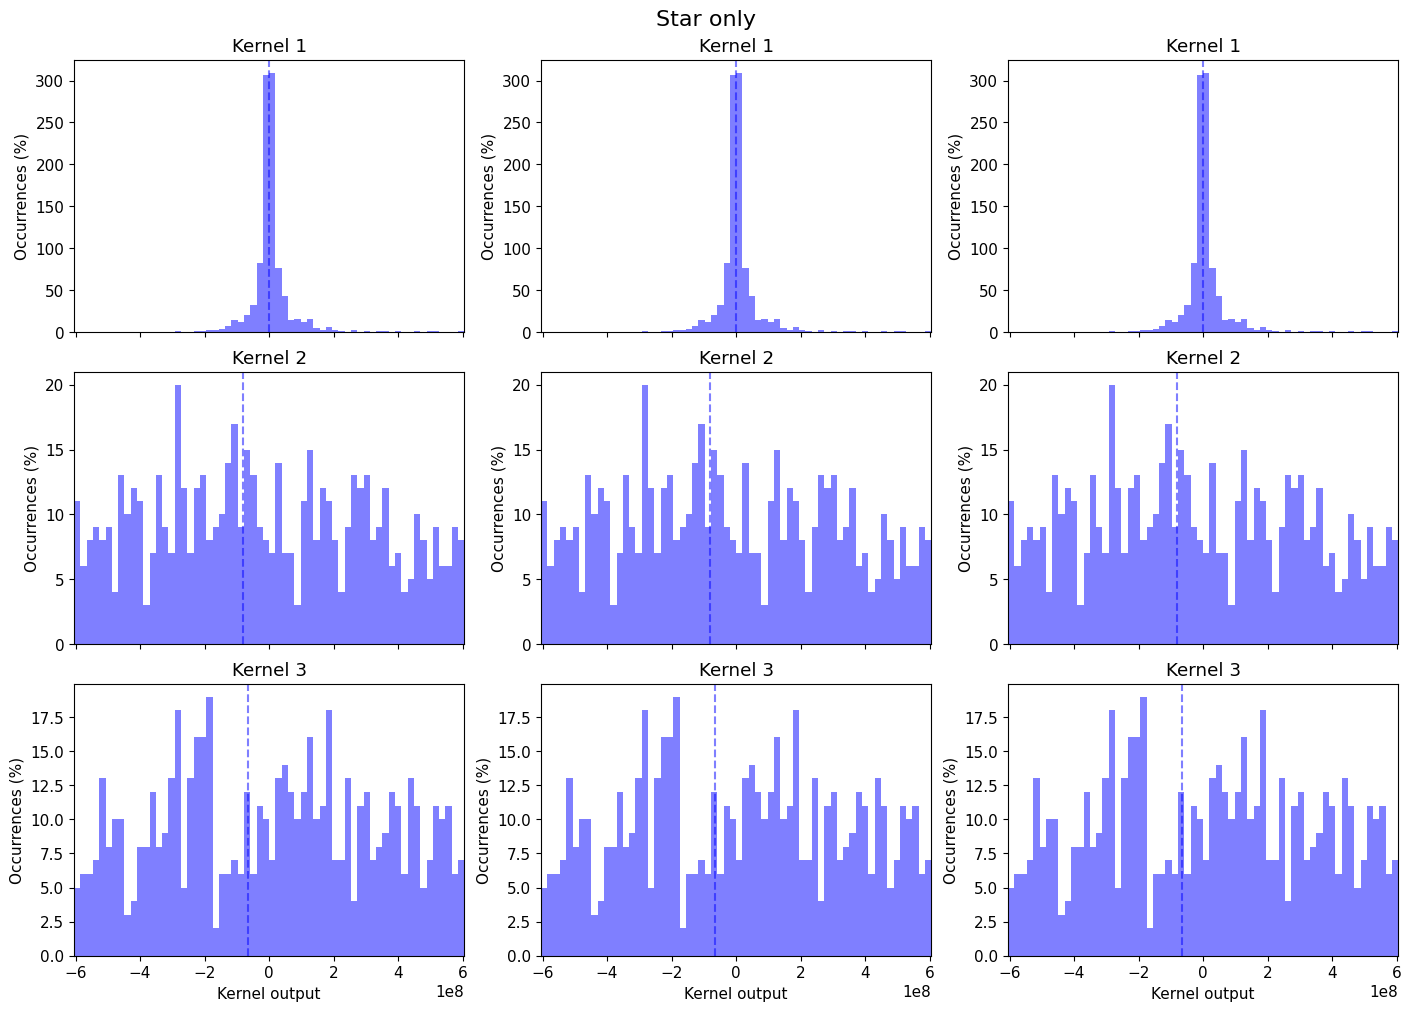

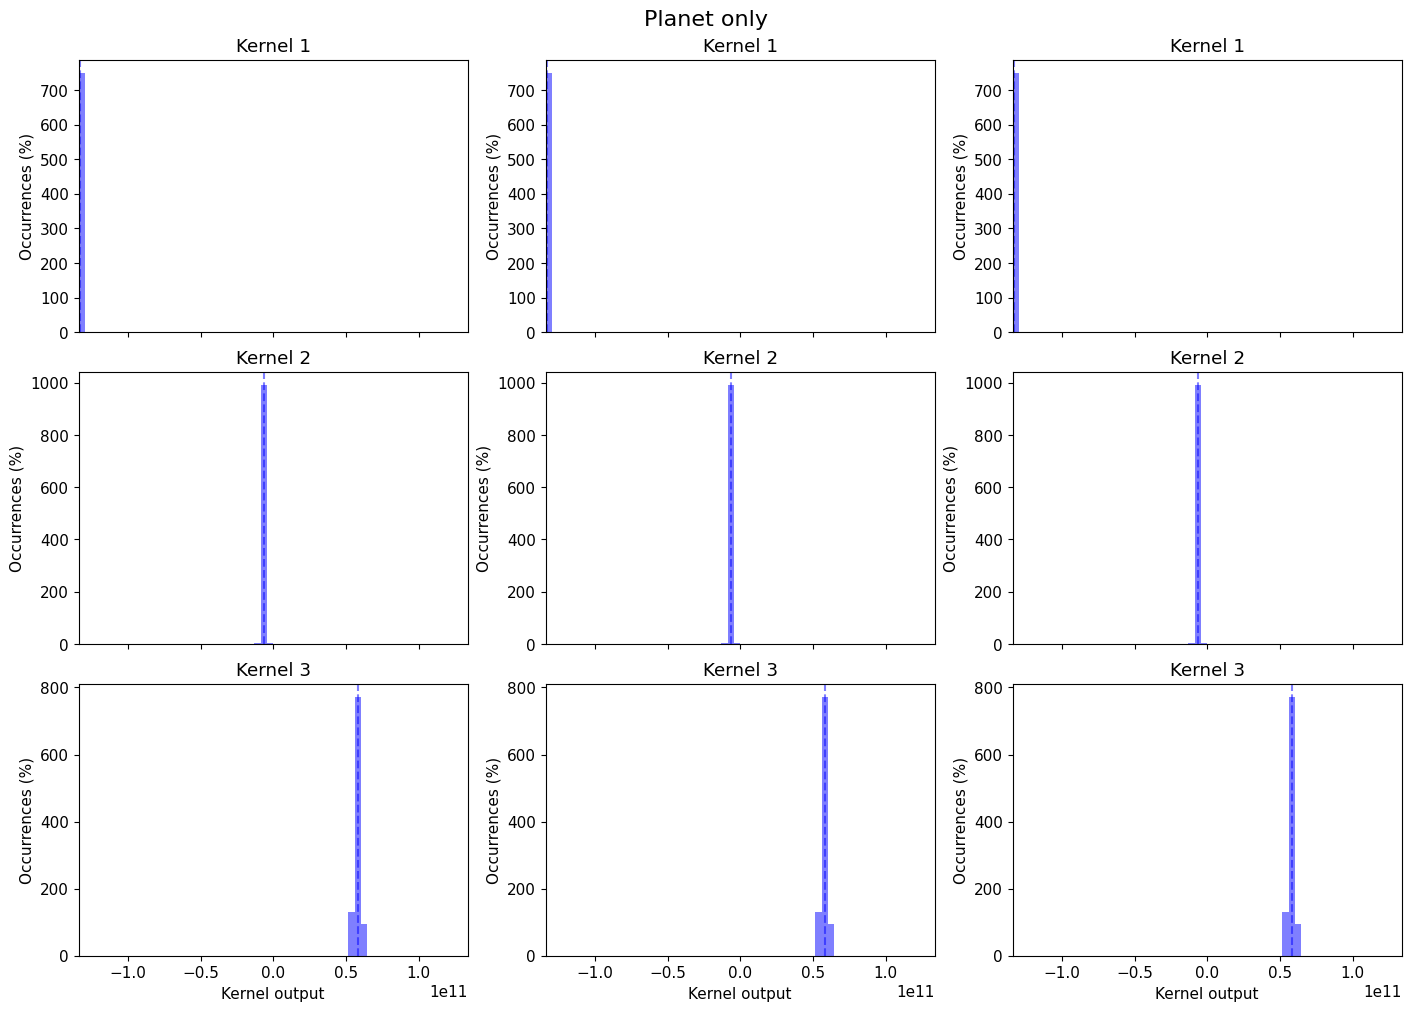

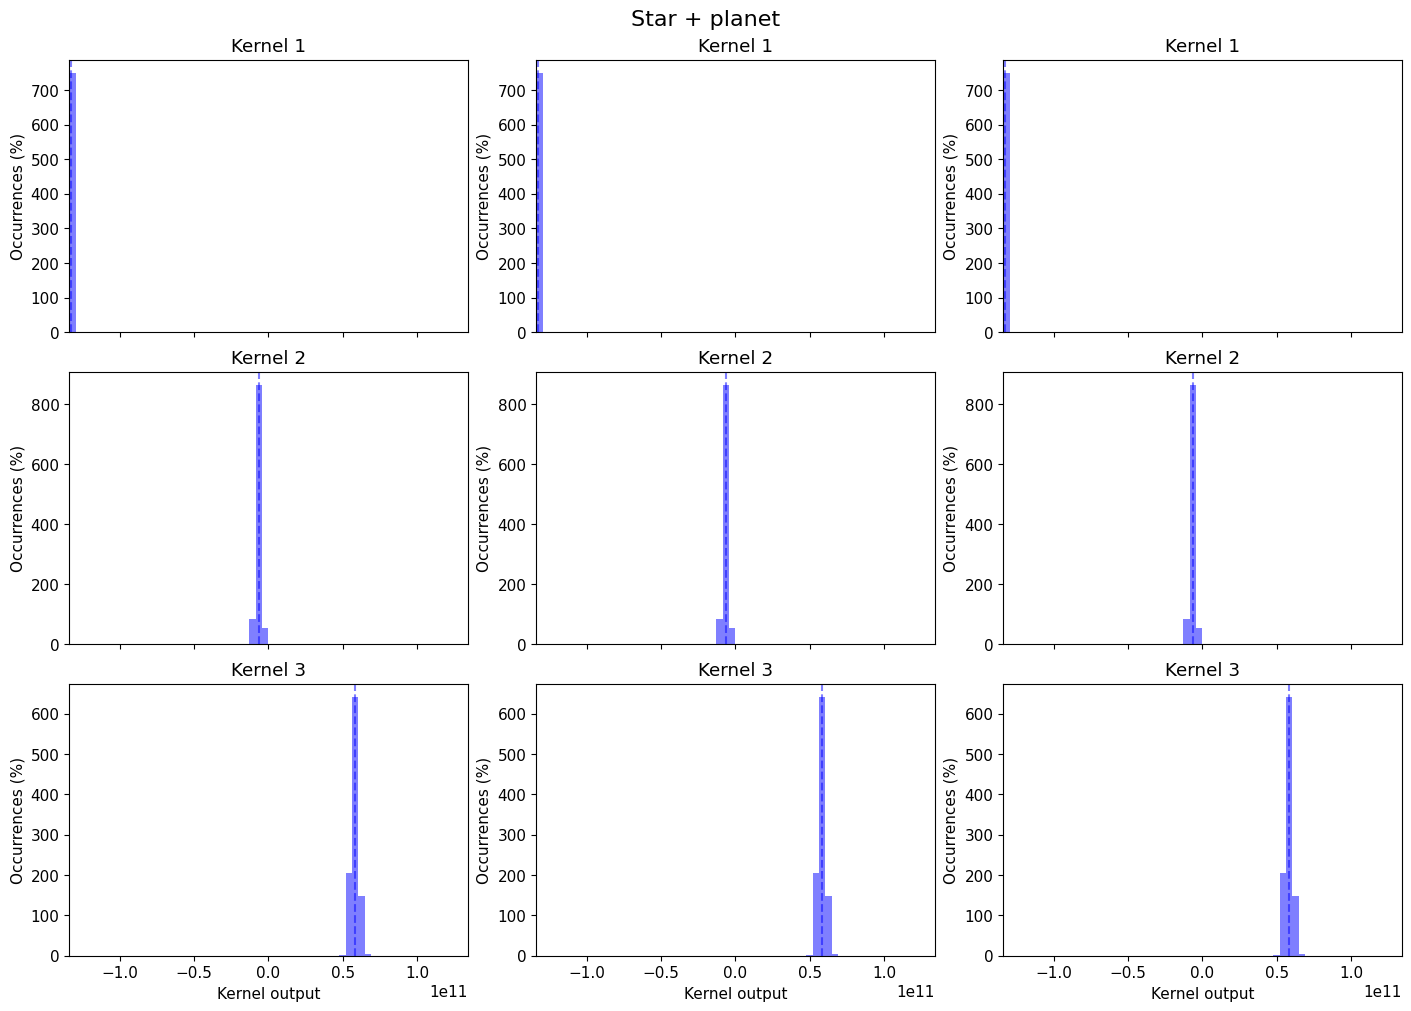

✓ Distribution instantanée calculée


In [3]:
# Calcul de la distribution instantanée
# Cela génère plusieurs figures comparant le modèle analytique et numérique
print("Calcul de la distribution instantanée...")
data, data_so = data_representations.instant_distribution(
    ctx=ctx,
    n=1000,  # Nombre d'observations
    stat=np.median,  # Statistique à utiliser
    figsize=(14, 10),
    sync_plots=True,  # Synchroniser les axes
    show=True,
    density=False,
    log=False,
)
print("✓ Distribution instantanée calculée")

## Analyse de la Distribution

### Observations Clés

1. **Symétrie des distributions** : Pour l'étoile seule, les noyaux sont centrés à zéro (interférence destructive optimale)
2. **Bruit analytique vs numérique** : Les deux modèles devraient montrer une bonne concordance
3. **Effet de la planète** : La compagne provoque une modulation des noyaux dépendant de :
   - Sa séparation angulaire
   - Son contraste
   - La longueur d'onde

### Signal de Détection

Pour un système avec étoile + compagne, on observe :
$$K(\alpha,\delta) = K_{\star} + K_{\mathrm{planet}} \approx K_{\mathrm{planet}}$$
car $K_{\star} \approx 0$ en nulling optimal.


## Évolution Temporelle

L'évolution temporelle analyse comment les sorties du nuller varient avec le changement d'angle horaire.
Cela simule l'observation d'une source pendant sa trajectoire dans le ciel.

### Phénomènes Observés
- **Variation du null** : Due à la géométrie du réseau qui change avec l'heure
- **Turbulence atmosphérique** : Cause des fluctuations aléatoires
- **Dispersion spectrale** : Différentes longueurs d'onde produisent des noyaux différents

In [4]:
# Évolution temporelle (implémentation locale pour contourner un bug d'API)
print("Calcul de l'évolution temporelle...")

# Préparation
h_range = ctx.get_h_range()
nb_h = len(h_range)
nb_k = ctx.interferometer.chip.nb_kernels if hasattr(ctx.interferometer.chip, 'nb_kernels') else 3

n = 100  # Nombre d'observations par angle horaire
map = np.median  # Statistique pour chaque angle

# Tableaux résultats
data_time = np.empty((nb_h, nb_k))
ref_data = np.empty((nb_h, nb_k))

for ih, h in enumerate(h_range):
    ctx.h = h

    # Empile n réalisations avec pistons atmosphériques
    outs_k = np.empty((n, nb_k))
    for j in range(n):
        # Génère un piston par télescope (1D)
        Δφ = np.random.normal(0, ctx.Γ.value, size=len(ctx.interferometer.telescopes)) * ctx.Γ.unit
        outs = ctx.observe(upstream_pistons=Δφ)
        outs_k[j, :] = ctx.interferometer.chip.process_outputs(outs)

    # Statistique par noyau sur n réalisations
    data_time[ih, :] = map(outs_k, axis=0)

    # Référence sans bruit
    outs_ref = ctx.observe()
    ref_data[ih, :] = ctx.interferometer.chip.process_outputs(outs_ref)

print("✓ Évolution temporelle calculée")
print(f"  Forme des données : {data_time.shape}")
print(f"  Nombre d'angles horaires : {data_time.shape[0]}")
print(f"  Nombre de noyaux : {data_time.shape[1]}")

Calcul de l'évolution temporelle...
✓ Évolution temporelle calculée
  Forme des données : (96, 3)
  Nombre d'angles horaires : 96
  Nombre de noyaux : 3


## Comparaison des Statistiques

Affichage détaillé de la comparaison entre le modèle analytique et les simulations numériques.

In [5]:
# Afficher des statistiques détaillées
print("\\n" + "="*60)
print("STATISTIQUES DES DISTRIBUTIONS")
print("="*60)

# Analyse de la distribution temporelle
print(f"\\nDistribution Temporelle:")
print(f"  Kernel 1: μ={np.mean(data_time[:, 0]):.2e}, σ={np.std(data_time[:, 0]):.2e}")
print(f"  Kernel 2: μ={np.mean(data_time[:, 1]):.2e}, σ={np.std(data_time[:, 1]):.2e}")
print(f"  Kernel 3: μ={np.mean(data_time[:, 2]):.2e}, σ={np.std(data_time[:, 2]):.2e}")

# Référence
print(f"\\nRéférence (sans bruit):")
print(f"  Kernel 1: {ref_data[0, 0]:.2e}")
print(f"  Kernel 2: {ref_data[0, 1]:.2e}")
print(f"  Kernel 3: {ref_data[0, 2]:.2e}")
print("\\n" + "="*60)

\n============================================================
STATISTIQUES DES DISTRIBUTIONS
\nDistribution Temporelle:
  Kernel 1: μ=-4.90e+10, σ=6.12e+10
  Kernel 2: μ=-1.78e+10, σ=2.31e+10
  Kernel 3: μ=6.19e+10, σ=3.81e+10
\nRéférence (sans bruit):
  Kernel 1: 1.26e+10
  Kernel 2: 1.95e+10
  Kernel 3: 3.28e+10
\n============================================================


## Vérification de la distribution instantanée

Nous comparons les distributions numériques et analytiques en réutilisant les mêmes réalisations d'erreurs de piston.

- `verify_distributions` appelle d'abord le modèle numérique, puis calcule la version analytique avec les mêmes OPD.
- Les figures montrent, pour chaque scénario (étoile seule, planète seule, complet), les histogrammes numériques (bleu) et analytiques (vert).

Pour limiter le temps de calcul, nous échantillonnons `n=2000` réalisations.

**Note**: Il est important de réinitialiser le contexte avant cette vérification pour éviter les corruptions de shallow copy.

Vérification numérique vs analytique...


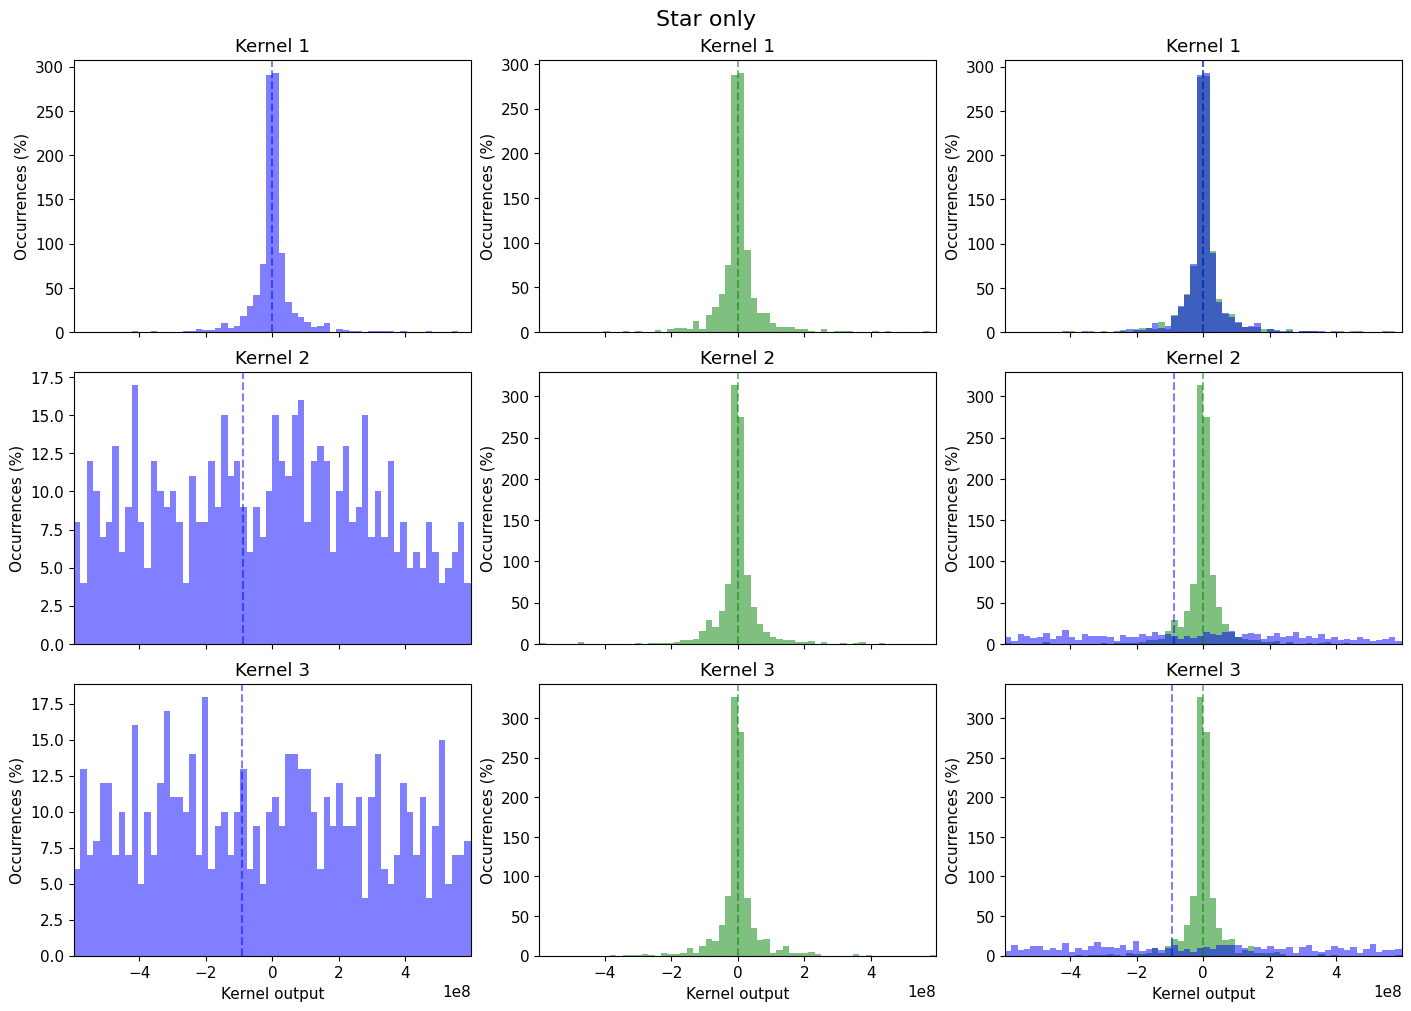

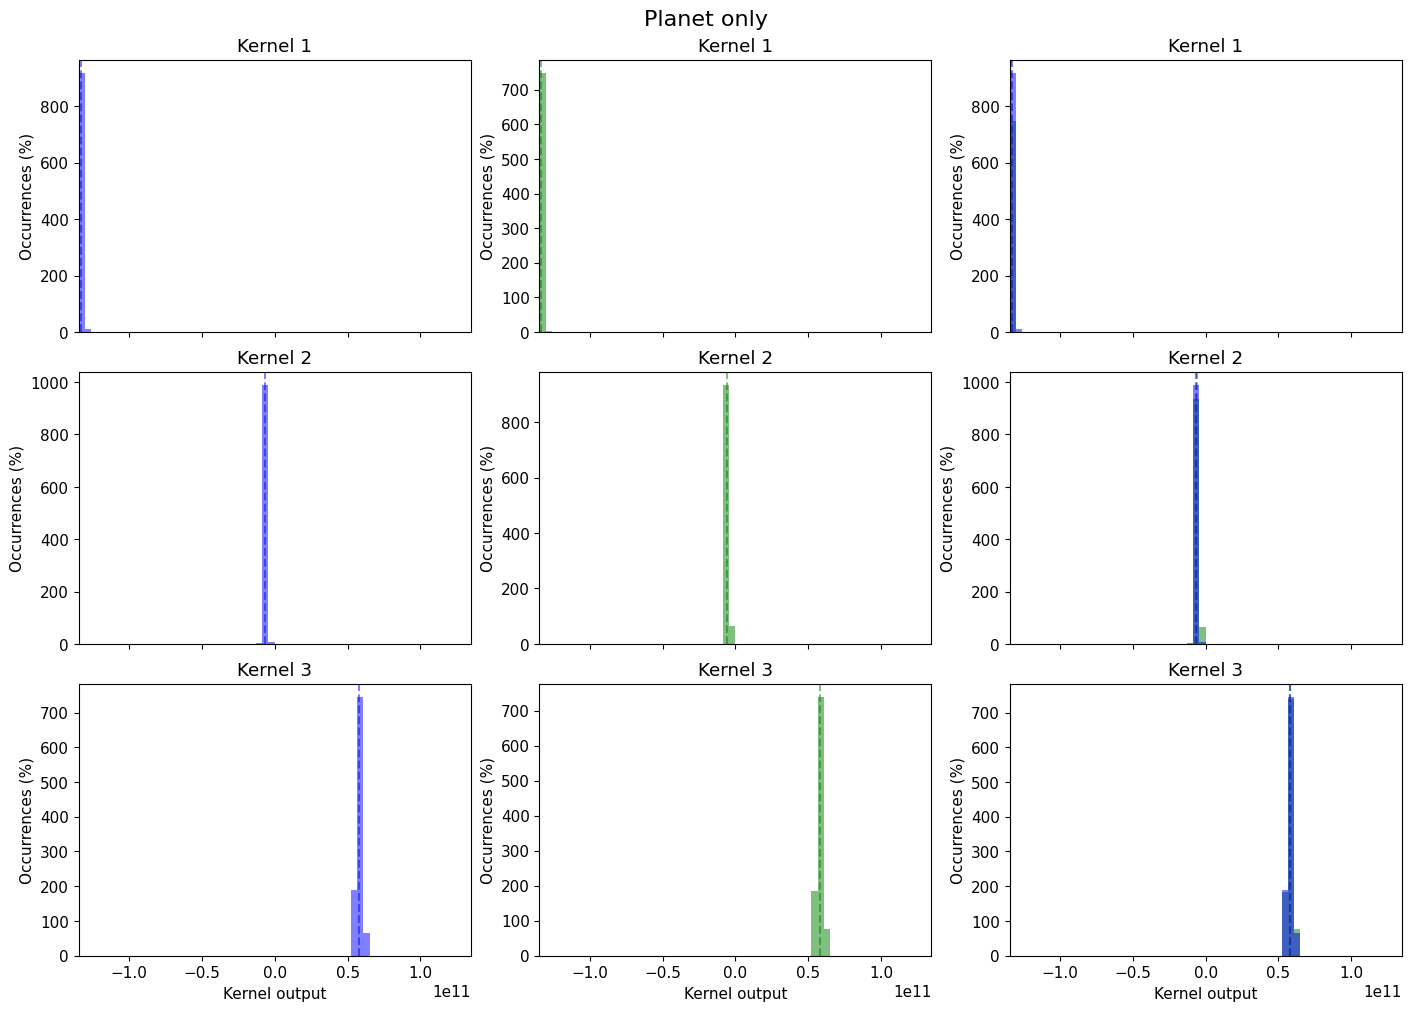

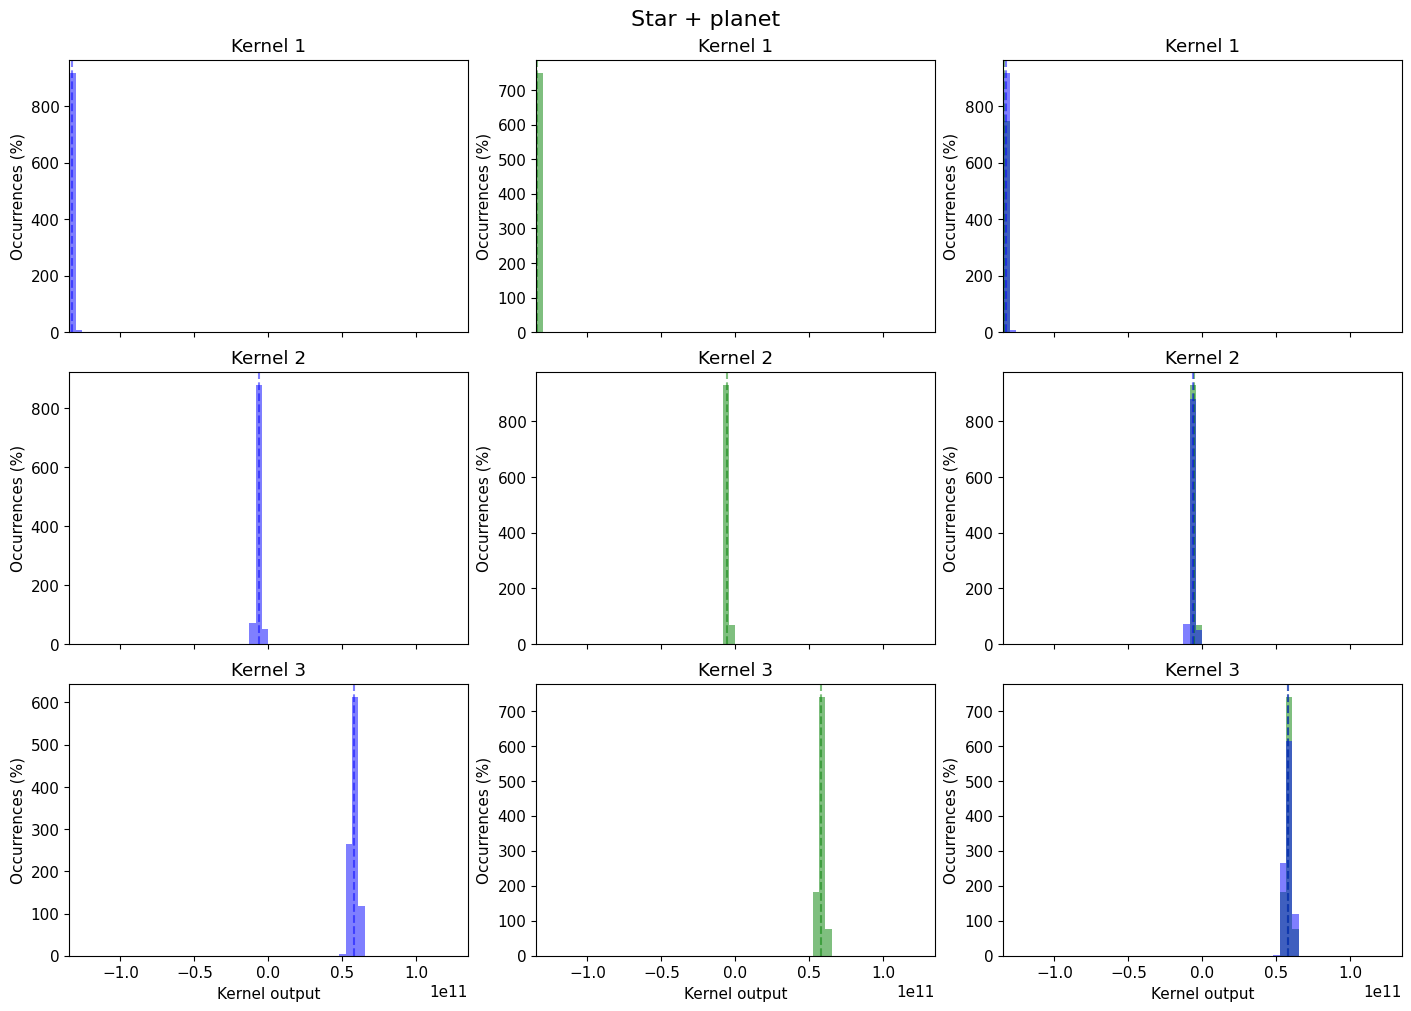

In [6]:
# Réinitialiser le contexte pour éviter les corruptions
ctx = Context.get_VLTI()
ctx.target.companions[0].c = 1e-2
ctx.interferometer.chip.σ = np.zeros(14) * u.nm
ctx.Γ = 5 * u.nm

# Vérification distribution instantanée (numérique vs analytique)
print("Vérification numérique vs analytique...")
verify_results = data_representations.verify_distributions(
    ctx=ctx,
    n=1000,  # Nombre d'échantillons pour chaque scénario
    stat=np.median,
    figsize=(14, 10),
    log=False,
    density=False,
    sync_plots=True,
    show=True,
    verbose=False
)